In [1]:
import pandas as pd
from music21 import converter, note, stream, chord
import itertools
import warnings
import random
import numpy as np
import ast
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, Activation
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import ast
import matplotlib.pyplot as plt
from collections import Counter
import joblib

warnings.filterwarnings("ignore")

In [2]:
#import de la table
path = '..\data\maestro-v3.0.0.csv'
df = pd.read_csv(path)

In [3]:
dfs = df.groupby('canonical_composer', group_keys=False).apply(lambda x: x.sample(frac=0.1, random_state=42))

In [4]:
def extraction_notes(file):
    '''
    Fonction pour extraires les notes d'un fichiers midi dans une liste
    avec les éléments int compris entre 0 et 127 
    Pour les accords on ne prend que la note la plus haute (la plus aigue)
    '''
    midi = converter.parse(file)
    L_notes = []
    for e in midi.recurse().notes:
        if e.isNote:
            N = e.pitch.midi
            L_notes.append(N)
        elif e.isChord:
            accords = [n.midi for n in e.pitches]
            N = max(accords)
            L_notes.append(N)
    if len(L_notes)<50:
        return 'null'
    else:
        return L_notes 
    
def ex_notes_tab(df,col_out):
    '''
    Création de la colonne contenant la liste des notes
    '''
    df['midi_file_data'] = '../data/'+df['midi_filename']
    df[col_out] = df['midi_file_data'].apply(extraction_notes)
    return df[df[col_out]!='null']

def sequence_list(L):
    ''' création des séquences de 50 notes et output cette liste et de la note suivante (cible)'''
    sequence_length = 50

    input_sequences = []
    output_notes = []

    for i in range(len(L) - sequence_length):
        seq_in = L[i:i + sequence_length]  
        seq_out = L[i + sequence_length]  
        input_sequences.append(seq_in)
        output_notes.append(seq_out)

    return input_sequences,output_notes

def sequence(dff):
    ''' 
    Application du séquencage à toutes les musiques
    '''
    X,y = [],[]
    for k in dff['notes'].to_list():
        xtemp,ytemp = sequence_list(k)
        X.append(xtemp)
        y.append(ytemp)
    X=list(itertools.chain(*X))
    y=list(itertools.chain(*y))

    return pd.DataFrame({"X":X,"y":y})

def colonnes(df):
    ''' mise en forme : 1 temps = 1 colonne = 1 note '''
    df_expanded = df['X'].apply(pd.Series)
    df_expanded['y'] = df['y']
    return df_expanded

In [5]:
#On ne sélectionne que toutes les 10 séquences pour limiter l'overfit probables si toutes
#les séquences sont presques identiques

dfs = colonnes(sequence(ex_notes_tab(dfs,'notes')))

i=0
L_retenu = []
while i<dfs.shape[0]:
    if (i==0) or (i%10==0):
        L_retenu.append(i)
    i+=1

dfs2 = dfs[dfs.index.isin(L_retenu)]

In [6]:
#split du train (70%),val et test (15%)
df_train, df_temp = train_test_split(dfs2, test_size=0.1, random_state=42)
df_val, df_test = train_test_split(df_temp, test_size=0.5, random_state=42)

#séparation pour les deux modèles -> octaves et notes
dfn_train,dfo_train = df_train.copy(),df_train.copy()
dfn_val,dfo_val = df_val.copy(),df_val.copy()
dfn_test,dfo_test = df_test.copy(),df_test.copy()

# pitch = octave * 12 + note
def def_octave(x):
    return x//12

def def_note(x):
    return x%12

for k in df_train:
    #recup des notes comme si les octaves n'existaient pas
    dfn_train[k] = dfn_train[k].apply(def_note)
    dfn_val[k] = dfn_val[k].apply(def_note)
    dfn_test[k] = dfn_test[k].apply(def_note)

    #recup des octaves comme si les notes n'existaient pas
    dfo_train[k] = dfo_train[k].apply(def_octave)
    dfo_val[k] = dfo_val[k].apply(def_octave)
    dfo_test[k] = dfo_test[k].apply(def_octave)

In [7]:
def df_to_tensor(df,num_classes):
    ''' mise en forme sous tenseurs avec les notes en tant que catégories '''
    col = [i for i in df.columns if i!='y']
    X_raw = df[col].values.astype(int)
    X = to_categorical(X_raw, num_classes=num_classes)
    y_raw = df["y"].astype(int).values
    y = to_categorical(y_raw, num_classes=num_classes)
    return X, y

#max d'octaves pris en compte par music21
nb_octave = 11
#Do, Do#, Ré, Ré#, Mi, Fa, Fa#, Sol, Sol#, La, La#, Si
nb_note = 12

Xo_train, yo_train = df_to_tensor(pd.DataFrame(dfo_train),nb_octave)
Xo_val, yo_val = df_to_tensor(pd.DataFrame(dfo_val),nb_octave)
Xo_test, yo_test = df_to_tensor(pd.DataFrame(dfo_test),nb_octave)

Xn_train, yn_train = df_to_tensor(pd.DataFrame(dfn_train),nb_note)
Xn_val, yn_val = df_to_tensor(pd.DataFrame(dfn_val),nb_note)
Xn_test, yn_test = df_to_tensor(pd.DataFrame(dfn_test),nb_note)


In [9]:
sequence_length = 50

modelo = Sequential()
modelo.add(LSTM(256, input_shape=(sequence_length, nb_octave), return_sequences=True))
modelo.add(Dropout(0.3))
modelo.add(LSTM(256))
modelo.add(Dropout(0.3))
modelo.add(Dense(nb_octave))
modelo.add(Activation('softmax'))

optimizer = RMSprop(learning_rate=0.001)
modelo.compile(loss='categorical_crossentropy', optimizer=optimizer)

historyo = modelo.fit(
    Xo_train, yo_train,
    validation_data=(Xo_val, yo_val),
    epochs=400,
    batch_size=32
)

Epoch 1/400
1058/1058 ━━━━━━━━━━━━━━━━━━━━ 59s 54ms/step - loss: 1.3766 - val_loss: 1.2525
Epoch 2/400
1058/1058 ━━━━━━━━━━━━━━━━━━━━ 63s 60ms/step - loss: 1.2523 - val_loss: 1.2586
Epoch 3/400
1058/1058 ━━━━━━━━━━━━━━━━━━━━ 67s 63ms/step - loss: 1.2421 - val_loss: 1.2256
Epoch 4/400
1058/1058 ━━━━━━━━━━━━━━━━━━━━ 67s 64ms/step - loss: 1.2457 - val_loss: 1.2696
Epoch 5/400
1058/1058 ━━━━━━━━━━━━━━━━━━━━ 68s 64ms/step - loss: 1.2370 - val_loss: 1.2306
Epoch 6/400
1058/1058 ━━━━━━━━━━━━━━━━━━━━ 67s 64ms/step - loss: 1.2312 - val_loss: 1.2044
Epoch 7/400
1058/1058 ━━━━━━━━━━━━━━━━━━━━ 67s 63ms/step - loss: 1.2251 - val_loss: 1.2090
Epoch 8/400
1058/1058 ━━━━━━━━━━━━━━━━━━━━ 67s 63ms/step - loss: 1.2231 - val_loss: 1.2120
Epoch 9/400
1058/1058 ━━━━━━━━━━━━━━━━━━━━ 67s 63ms/step - loss: 1.2241 - val_loss: 1.1991
Epoch 10/400
1058/1058 ━━━━━━━━━━━━━━━━━━━━ 67s 63ms/step - loss: 1.2201 - val_loss: 1.2186
Epoch 11/400
1058/1058 ━━━━━━━━━━━━━━━━━━━━ 67s 63ms/step - loss: 1.2225 - val_loss: 1.20

In [10]:
modeln = Sequential()
modeln.add(LSTM(256, input_shape=(sequence_length, nb_note), return_sequences=True))
modeln.add(Dropout(0.3))
modeln.add(LSTM(256))
modeln.add(Dropout(0.3))
modeln.add(Dense(nb_note))
modeln.add(Activation('softmax'))

optimizer = RMSprop(learning_rate=0.001)
modeln.compile(loss='categorical_crossentropy', optimizer=optimizer)

historyn = modeln.fit(
    Xn_train, yn_train,
    validation_data=(Xn_val, yn_val),
    epochs=400,
    batch_size=32
)

Epoch 1/400
1058/1058 ━━━━━━━━━━━━━━━━━━━━ 73s 67ms/step - loss: 2.2986 - val_loss: 2.2303
Epoch 2/400
1058/1058 ━━━━━━━━━━━━━━━━━━━━ 71s 67ms/step - loss: 2.2244 - val_loss: 2.2125
Epoch 3/400
1058/1058 ━━━━━━━━━━━━━━━━━━━━ 70s 66ms/step - loss: 2.2101 - val_loss: 2.2182
Epoch 4/400
1058/1058 ━━━━━━━━━━━━━━━━━━━━ 70s 66ms/step - loss: 2.1982 - val_loss: 2.1909
Epoch 5/400
1058/1058 ━━━━━━━━━━━━━━━━━━━━ 70s 66ms/step - loss: 2.1796 - val_loss: 2.1739
Epoch 6/400
1058/1058 ━━━━━━━━━━━━━━━━━━━━ 70s 66ms/step - loss: 2.1810 - val_loss: 2.1785
Epoch 7/400
1058/1058 ━━━━━━━━━━━━━━━━━━━━ 70s 66ms/step - loss: 2.1745 - val_loss: 2.1735
Epoch 8/400
1058/1058 ━━━━━━━━━━━━━━━━━━━━ 70s 66ms/step - loss: 2.1636 - val_loss: 2.1580
Epoch 9/400
1058/1058 ━━━━━━━━━━━━━━━━━━━━ 70s 66ms/step - loss: 2.1492 - val_loss: 2.1603
Epoch 10/400
1058/1058 ━━━━━━━━━━━━━━━━━━━━ 71s 67ms/step - loss: 2.1507 - val_loss: 2.1566
Epoch 11/400
1058/1058 ━━━━━━━━━━━━━━━━━━━━ 67s 63ms/step - loss: 2.1335 - val_loss: 2.15

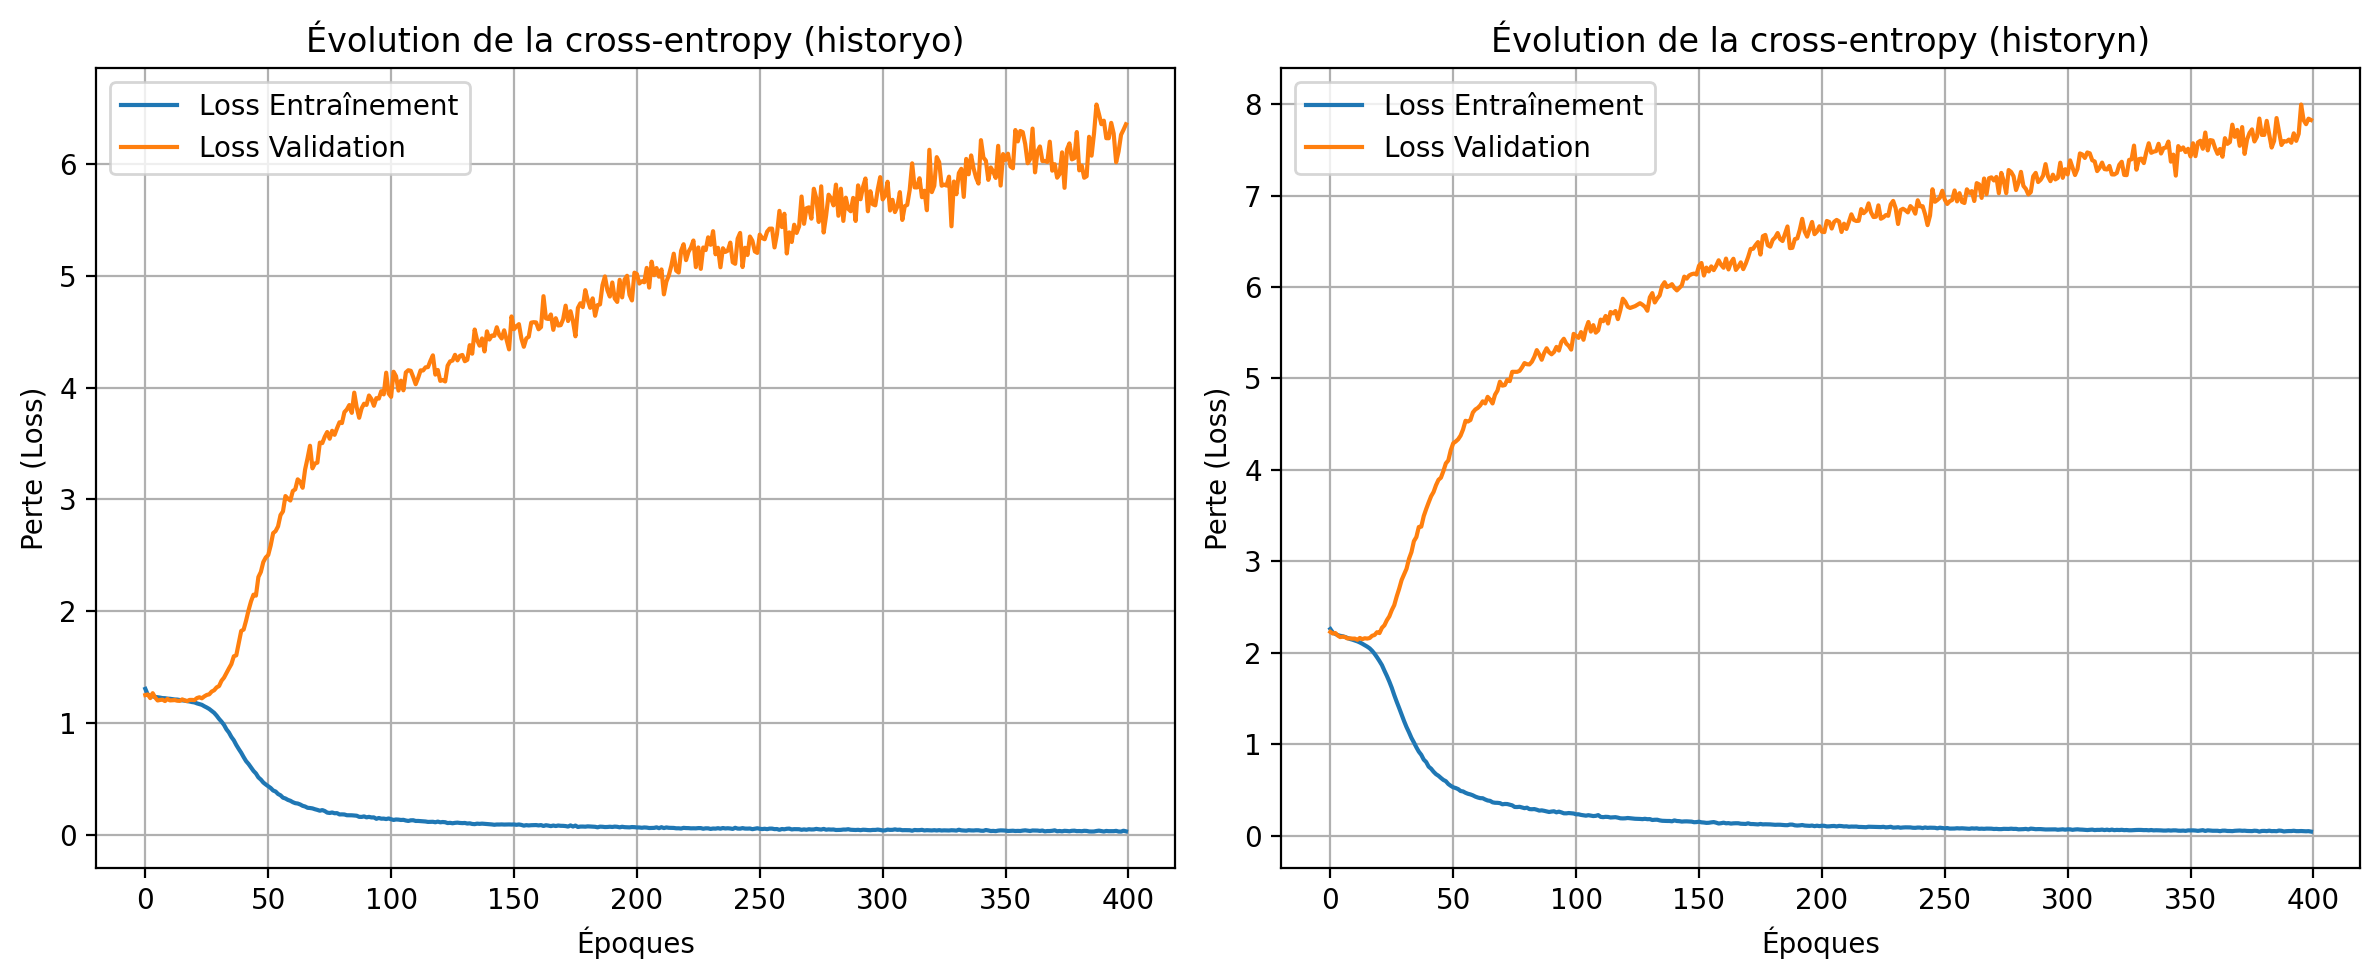

In [11]:
losso = historyo.history['loss']
val_losso = historyo.history['val_loss']

lossn = historyn.history['loss']
val_lossn = historyn.history['val_loss']


fig, axs = plt.subplots(1, 2, figsize=(12, 5))


axs[0].plot(losso, label='Loss Entraînement')
axs[0].plot(val_losso, label='Loss Validation')
axs[0].set_title('Évolution de la cross-entropy (historyo)')
axs[0].set_xlabel('Époques')
axs[0].set_ylabel('Perte (Loss)')
axs[0].legend()
axs[0].grid(True)

axs[1].plot(lossn, label='Loss Entraînement')
axs[1].plot(val_lossn, label='Loss Validation')
axs[1].set_title('Évolution de la cross-entropy (historyn)')
axs[1].set_xlabel('Époques')
axs[1].set_ylabel('Perte (Loss)')
axs[1].legend()
axs[1].grid(True)


plt.tight_layout()
plt.show()

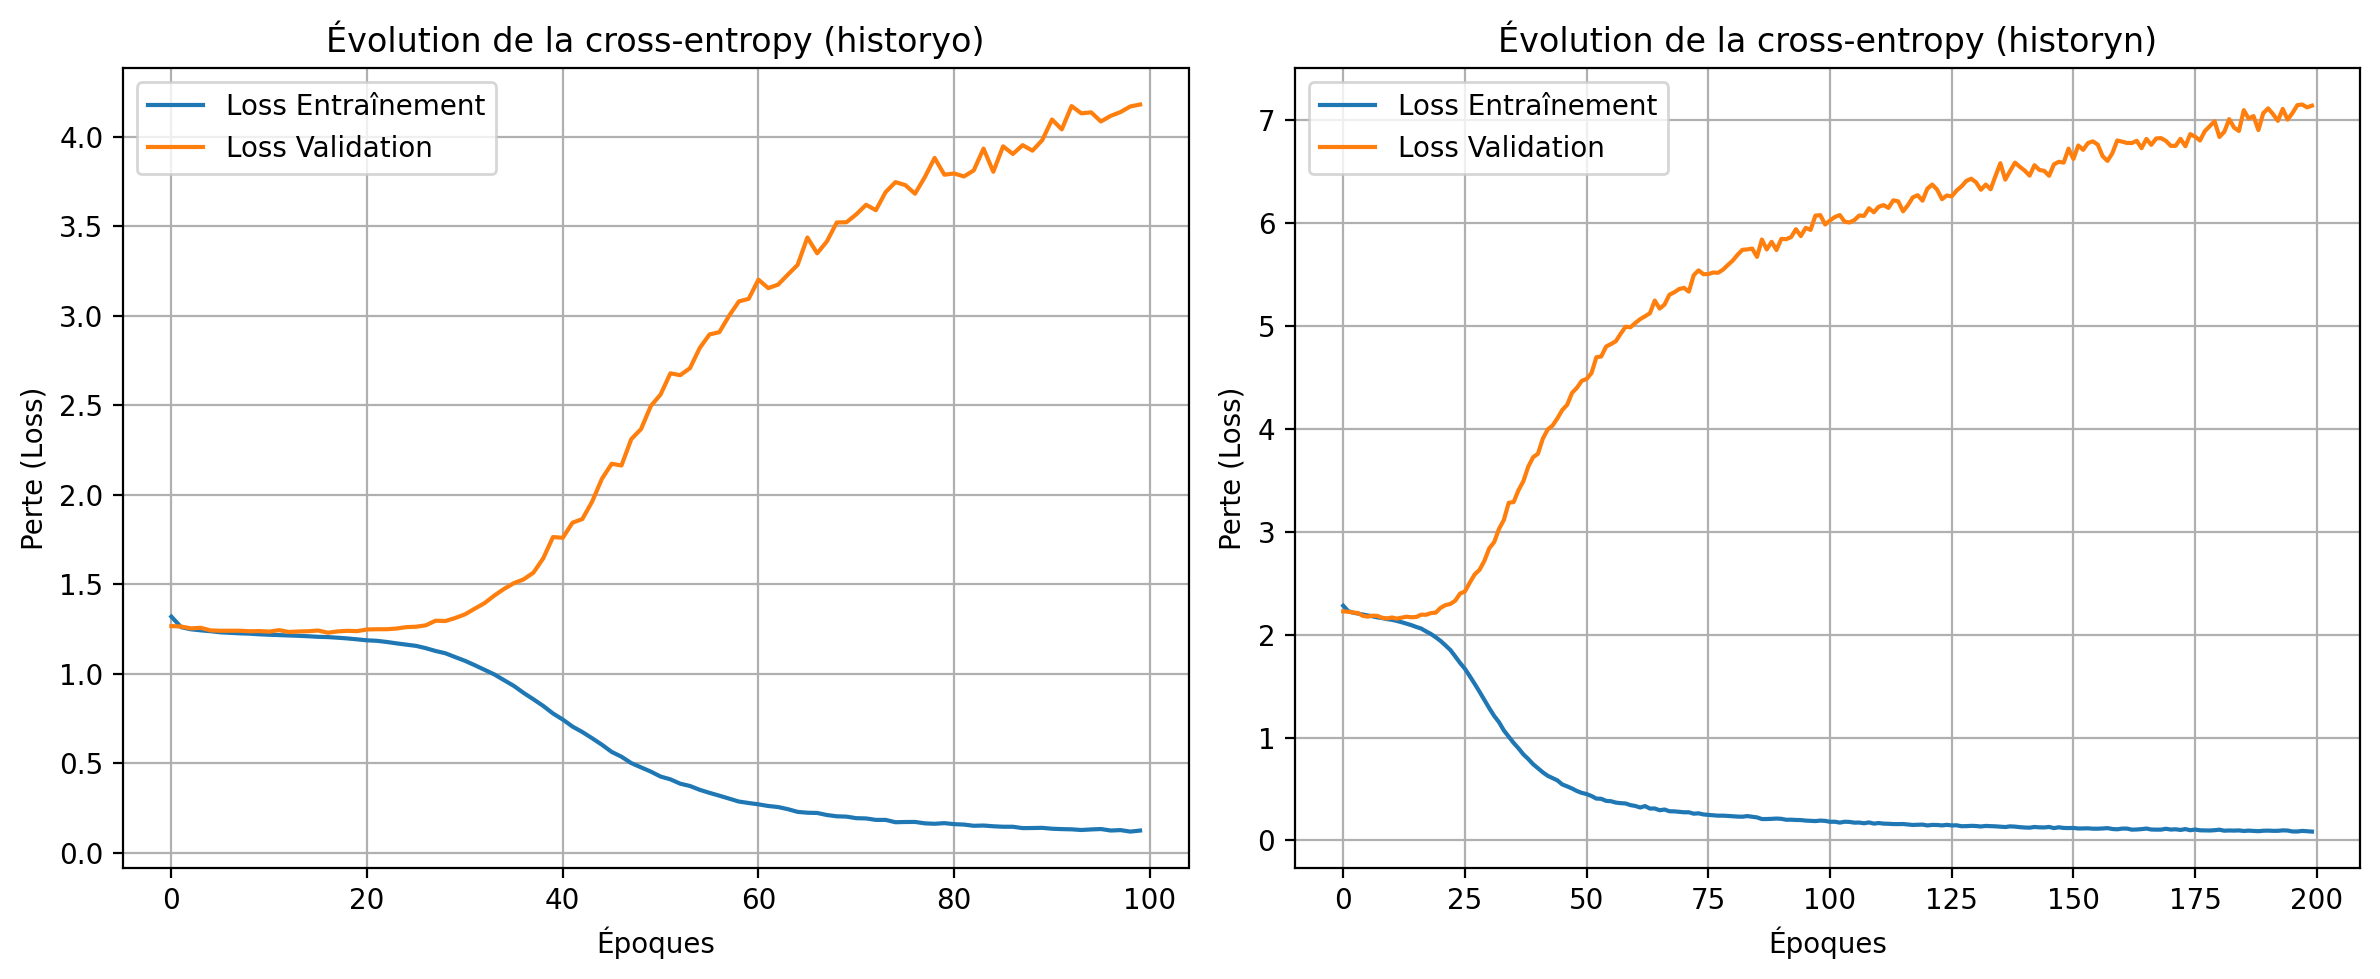

In [25]:
losso = historyo.history['loss']
val_losso = historyo.history['val_loss']

lossn = historyn.history['loss']
val_lossn = historyn.history['val_loss']


fig, axs = plt.subplots(1, 2, figsize=(12, 5))


axs[0].plot(losso, label='Loss Entraînement')
axs[0].plot(val_losso, label='Loss Validation')
axs[0].set_title('Évolution de la cross-entropy (historyo)')
axs[0].set_xlabel('Époques')
axs[0].set_ylabel('Perte (Loss)')
axs[0].legend()
axs[0].grid(True)

axs[1].plot(lossn, label='Loss Entraînement')
axs[1].plot(val_lossn, label='Loss Validation')
axs[1].set_title('Évolution de la cross-entropy (historyn)')
axs[1].set_xlabel('Époques')
axs[1].set_ylabel('Perte (Loss)')
axs[1].legend()
axs[1].grid(True)


plt.tight_layout()
plt.show()

In [12]:
import joblib

joblib.dump(modelo, 'model_octave2.pkl')
joblib.dump(modeln, 'model_note2.pkl')

['model_note2.pkl']

In [13]:
def generate_sequence_octave(seed_sequence, model=modelo, length=50, noise_std=0.0):
    '''fonction qui permet de générer une séquence de 100 notes après l'apprentissage du modèle '''
    generated = list(seed_sequence)

    for _ in range(length):
        
        input_seq_raw = generated[-50:]
        input_seq = to_categorical(input_seq_raw, num_classes=nb_octave).reshape(1, 50, nb_octave)

        # Prédiction
        pred_distribution = model.predict(input_seq, verbose=0)[0] 
        
        #Ajout de bruit
        if noise_std > 0.0:
            pred_distribution += np.random.normal(0, noise_std, size=pred_distribution.shape)
        
        #Note la plus probable
        next_val = int(np.argmax(pred_distribution))
        generated.append(next_val)

    return generated

def generate_sequence_note(seed_sequence, model=modeln, length=50, noise_std=0.0):
    '''fonction qui permet de générer une séquence de 100 notes après l'apprentissage du modèle '''
    generated = list(seed_sequence)

    for _ in range(length):
        
        input_seq_raw = generated[-50:]
        input_seq = to_categorical(input_seq_raw, num_classes=nb_note).reshape(1, 50, nb_note)

        # Prédiction
        pred_distribution = model.predict(input_seq, verbose=0)[0] 
        
        #Ajout de bruit
        if noise_std > 0.0:
            pred_distribution += np.random.normal(0, noise_std, size=pred_distribution.shape)
        
        #Note la plus probable
        next_val = int(np.argmax(pred_distribution))
        generated.append(next_val)

    return generated



ligne_seed = random.randint(0,df_test.shape[0]-1) #Choix aléatoire de la seed dans l'ensemble de test
seed_sequence_octave = dfo_test.iloc[ligne_seed, :50].astype(int).tolist()
seed_sequence_note = dfn_test.iloc[ligne_seed, :50].astype(int).tolist()

generated_octave = generate_sequence_octave(seed_sequence=seed_sequence_octave,model=modelo, length=100, noise_std=2.0)
generated_note = generate_sequence_note(seed_sequence=seed_sequence_note,model=modeln, length=100, noise_std=2.0)

In [14]:
def generate_music(generated_octave,generated_note):
    generated_music = []
    for i in range(len(generated_octave)):
        o,n = generated_octave[i],generated_note[i]
        generated_music.append(o*12+n)
    return generated_music

generated_music = generate_music(generated_octave,generated_note)


In [15]:
#Affichage du résultat non applati
s = stream.Stream()
duration = 0.5  # durée en quarts de note pour les notes générées

for e in generated_music:
    e = note.Note(e)
    e.quarterLength = duration
    s.append(e)

s.show('midi')

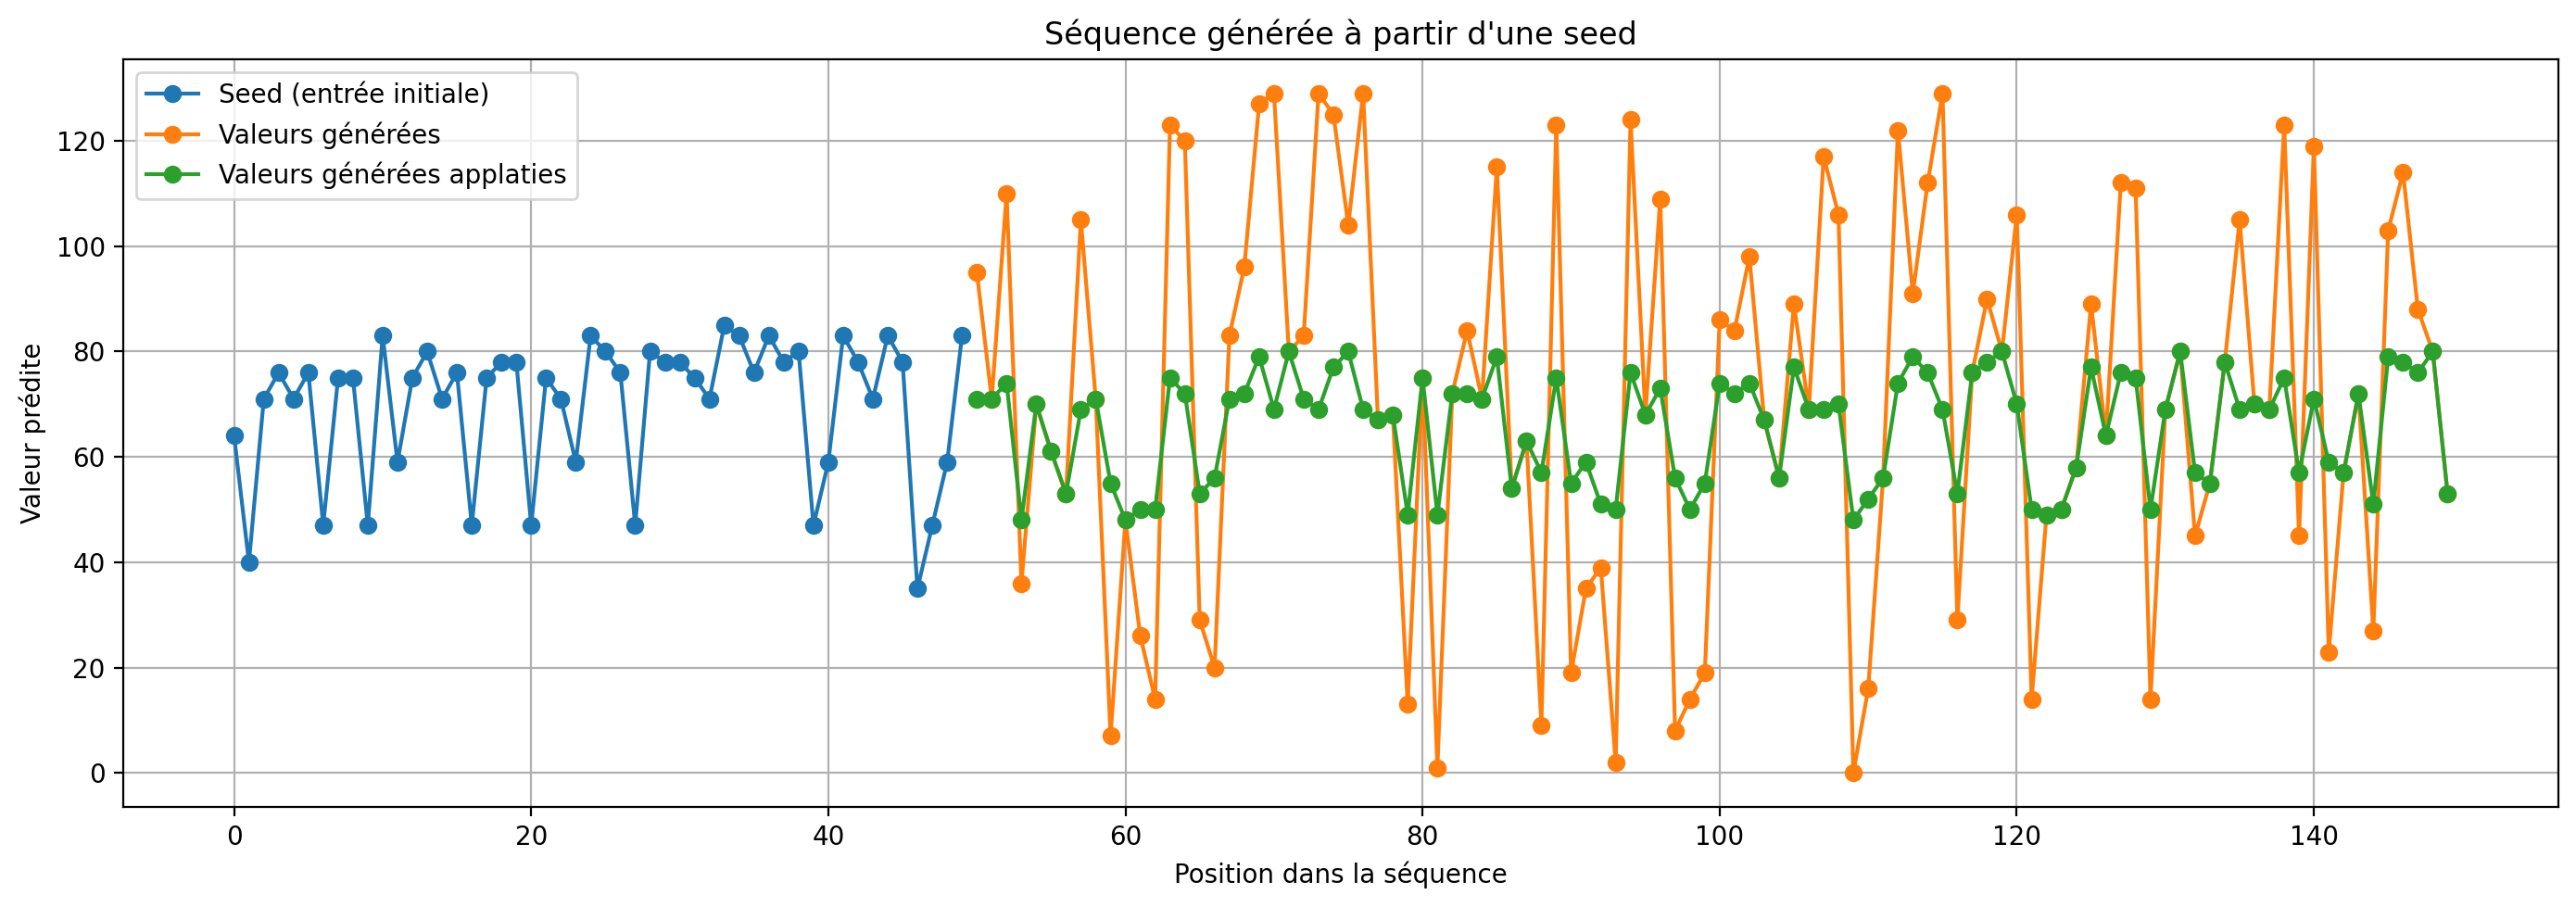

In [16]:
seed_sequence = generate_music(seed_sequence_octave,seed_sequence_note)

def applatissement(generated):
    ''' fonction qui permet "d'applatir" les notes à des 
    octaves plus raisonnables sans changer les notes pour 
    mieux rendre à l'oreille '''
    generated2 = []
    for k in range(len(generated)):
        n = generated[k]
        if k == 0:
            generated2.append(n)
        else:
            while n < 48: #note minimale pour une mélodie
                n+=12 #un octave en plus
            while n > 80: #note max mélodie
                n-=12 #un octave en moins
            generated2.append(n)
    return generated2

generated2 = applatissement(generated_music)



#Visualisation de la génération
plt.figure(figsize=(14, 5))
plt.plot(range(len(seed_sequence)), seed_sequence, label='Seed (entrée initiale)', marker='o')
plt.plot(range(len(seed_sequence), len(generated_music)), generated_music[len(seed_sequence):], label='Valeurs générées', marker='o')
plt.plot(range(len(seed_sequence), len(generated2)), generated2[len(seed_sequence):], label='Valeurs générées applaties', marker='o')
plt.title("Séquence générée à partir d'une seed")
plt.xlabel("Position dans la séquence")
plt.ylabel("Valeur prédite")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [17]:
#Affichage du résultat non applati
s = stream.Stream()
duration = 0.5  # durée en quarts de note pour les notes générées

for e in generated2:
    e = note.Note(e)
    e.quarterLength = duration
    s.append(e)

s.show('midi')